# Autoencoder

An **Autoencoder** is a neural network that first compresses the input data into a lower dimensional latent space and then reconstructs the output from this representation. 

To train an autoencoder for the task of classification, there are three steps. 

1. Train the full autoencoder model with encoder and decoder. 
   * The Mean Square Error (MSE) loss function can be used to calculate the loss of the reconstructed images.
2. Replace the decoder with fully connected layers, freeze the encoder layers, and train the model on classification. 
   * This allows the fully connected layers to learn the image features without changing the encoder's weights and bias. 
   * The Cross Entropy loss function can be used to calculate the loss. 
3. Unfreeze the encoder layers and train the model. This will lead to better performance by the model. 

## Definitions

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import display
from PIL import Image
import random
import pickle
import pathlib

def show_samples(samples):
    x = int(len(samples) / 2)
    y = len(samples) - x
    for i in range(len(samples)):
        plt.subplot(x, y, i + 1)
        plt.subplots_adjust(hspace=1)
        plt.imshow(samples[i][0], cmap='gray')
        plt.title("Uninfected" if samples[i][1] else "Infected", loc='center')
        plt.ylabel(f"Height ({samples[i][0].shape[0]})")
        plt.xlabel(f"Width ({samples[i][0].shape[1]})")
    plt.show()


class MalariaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.n_samples = len(dataframe)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        image, label = self.dataframe[index]
        if self.transform: 
            image = self.transform(image)
        return image, label


class Autoencoder(nn.Module):
    def __init__(self): 
        super().__init__()
        # 32 - 30 - 15 - 13 - 6 - 4 - 2
        self.Encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3), 
            nn.ReLU(), 
            nn.MaxPool2d(2), 
            nn.Conv2d(16, 8, 3), 
            nn.ReLU(), 
            nn.MaxPool2d(2), 
            nn.ReLU(), 
            nn.Conv2d(8, 4, 3), 
            nn.ReLU(), 
            nn.MaxPool2d(2),
        )
        # 2 - 4 - 6 - 12 - 14 - 28 - 30 - 32
        self.Decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'), 
            nn.ConvTranspose2d(4, 8, 3), 
            nn.ReLU(), 
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(8, 16, 3), 
            nn.ReLU(), 
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(16, 16, 3), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3), 
            nn.ReLU(),
        )
    
    def forward(self, input): 
        output = self.Encoder(input)
        output = self.Decoder(output)
        return output
        

class Encoder(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 1), 
            nn.Conv2d(16, 8, 3), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 1), 
            nn.ReLU(), 
            nn.Conv2d(8, 4, 3), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 1),
        )
        self.FC = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * 23 * 23, 512),
            nn.ReLU(),
            nn.Linear(512, 16), 
            nn.ReLU(),
            nn.Linear(16, 1),
        )
    
    def forward(self, input): 
        output = self.Encoder(input)
        # print(output.shape)
        output = self.FC(output)
        return output


def evaluate(model, loader): 
    total_err = 0
    total_samples = 0
    for images, labels in loader: 
        total_err += int(((model(images) > 0.0).squeeze().long() != labels).sum())
        total_samples += len(labels)
    return float(total_err) / total_samples

## Loading Data

In [43]:
input_size = 32
data_dir = f"../data/corrected_{input_size}.pickle"
df = pd.read_pickle(data_dir)

In [44]:
np.random.seed(1000)
np_df = df.to_numpy()
np.random.shuffle(np_df)
df_trn = np_df[:int(len(np_df) * 0.8)]
df_val = np_df[int(len(np_df) * 0.8):]

batch_size = 32

train_dataset = MalariaDataset(df_trn, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = MalariaDataset(df_val, transform=transforms.ToTensor())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Full Autoencoder

### Setup

In [73]:
num_steps = len(train_loader)
learning_rate = 0.001
num_epochs = 10

torch.manual_seed(1000)
model = Autoencoder()
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Training

In [74]:
for epoch in range(num_epochs):
    running_loss = 0
    for images, _ in train_loader: 
        # forward pass
        outputs = model(images)
        loss_value = loss(outputs, images)
        # backward pass
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        # loss 
        running_loss += loss_value.item()
    print(f"Epoch: {epoch + 1}/{num_epochs}, Loss: {float(running_loss) / num_steps:.4f}")

torch.save(model.state_dict(), "encoder.pth")

Epoch: 1/10, Loss: 0.0343
Epoch: 2/10, Loss: 0.0173
Epoch: 3/10, Loss: 0.0157
Epoch: 4/10, Loss: 0.0148
Epoch: 5/10, Loss: 0.0141
Epoch: 6/10, Loss: 0.0135
Epoch: 7/10, Loss: 0.0128
Epoch: 8/10, Loss: 0.0122
Epoch: 9/10, Loss: 0.0120
Epoch: 10/10, Loss: 0.0118


## Freezing Encoder Layers

In [94]:
encoder = Encoder()

for i, (encoder_param, param) in enumerate(zip(encoder.parameters(), model.parameters())): 
    if i < 6: 
        encoder_param.data = param.data
        encoder_param.requires_grad = False

loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(encoder.parameters(), lr=0.001)

In [ ]:
for i, param in enumerate(encoder.parameters()): 
    print(param.requires_grad)

Epoch 1/30, Loss: 0.661382, Validation Error: 0.443940
Epoch 2/30, Loss: 0.652308, Validation Error: 0.425980
Epoch 3/30, Loss: 0.658619, Validation Error: 0.439405
Epoch 4/30, Loss: 0.651078, Validation Error: 0.437591
Epoch 5/30, Loss: 0.658666, Validation Error: 0.427431
Epoch 6/30, Loss: 0.651698, Validation Error: 0.419811
Epoch 7/30, Loss: 0.645308, Validation Error: 0.413643
Epoch 8/30, Loss: 0.635493, Validation Error: 0.402939
Epoch 9/30, Loss: 0.636386, Validation Error: 0.400943
Epoch 10/30, Loss: 0.634571, Validation Error: 0.400036
Epoch 11/30, Loss: 0.638524, Validation Error: 0.398222
Epoch 12/30, Loss: 0.636561, Validation Error: 0.394775
Epoch 13/30, Loss: 0.639486, Validation Error: 0.402032
Epoch 14/30, Loss: 0.640354, Validation Error: 0.397859
Epoch 15/30, Loss: 0.642340, Validation Error: 0.400218
Epoch 16/30, Loss: 0.633433, Validation Error: 0.400218
Epoch 17/30, Loss: 0.636363, Validation Error: 0.401851
Epoch 18/30, Loss: 0.627353, Validation Error: 0.395319
E

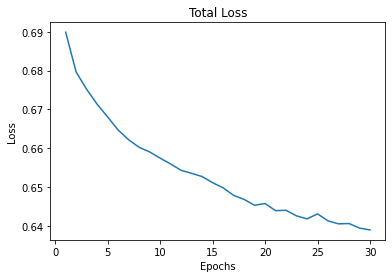

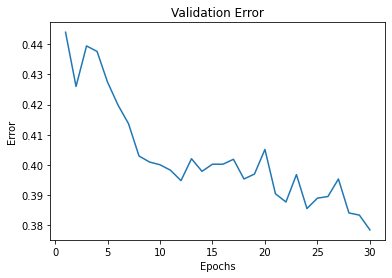

In [95]:
num_epochs = 30

train_loss = np.zeros(num_epochs)
val_error = np.zeros(num_epochs)

for epoch in range(num_epochs):
    running_loss = 0 
    for images, labels in train_loader: 
        # ensure labels are same size and type
        labels = labels.unsqueeze(1).float()
        # forward pass
        outputs = encoder(images)
        loss_value = loss(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        # for statistics
        running_loss += loss_value.item()
    # compute average loss 
    train_loss[epoch] = running_loss / num_steps
    # evaluate on validation set
    val_error[epoch] = evaluate(encoder, val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_value.item():.6f}, Validation Error: {val_error[epoch]:.6f}")

# show total loss
plt.title("Total Loss")
plt.plot(range(1, len(train_loss) + 1), train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.title("Validation Error")
plt.plot(range(1, len(val_error) + 1), val_error)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## Unfreezing Encoder Layers

In [96]:
for i, param in enumerate(encoder.parameters()): 
    if i < 6: param.requires_grad = True

### Training

Epoch 1/50, Loss: 0.432311, Validation Error: 0.292816
Epoch 2/50, Loss: 0.373474, Validation Error: 0.224964
Epoch 3/50, Loss: 0.120792, Validation Error: 0.090167
Epoch 4/50, Loss: 0.074165, Validation Error: 0.042997
Epoch 5/50, Loss: 0.048626, Validation Error: 0.028483
Epoch 6/50, Loss: 0.049352, Validation Error: 0.025036
Epoch 7/50, Loss: 0.033752, Validation Error: 0.022859
Epoch 8/50, Loss: 0.037953, Validation Error: 0.026488
Epoch 9/50, Loss: 0.035277, Validation Error: 0.026125
Epoch 10/50, Loss: 0.022993, Validation Error: 0.024311
Epoch 11/50, Loss: 0.012856, Validation Error: 0.023041
Epoch 12/50, Loss: 0.009788, Validation Error: 0.023041
Epoch 13/50, Loss: 0.005047, Validation Error: 0.022134
Epoch 14/50, Loss: 0.003949, Validation Error: 0.023948
Epoch 15/50, Loss: 0.009174, Validation Error: 0.024855
Epoch 16/50, Loss: 0.002829, Validation Error: 0.024673
Epoch 17/50, Loss: 0.002892, Validation Error: 0.024673
Epoch 18/50, Loss: 0.000812, Validation Error: 0.023041
E

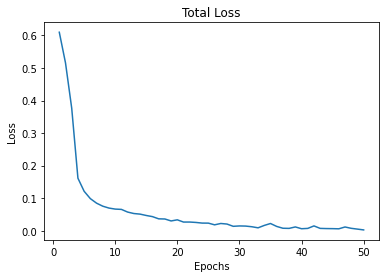

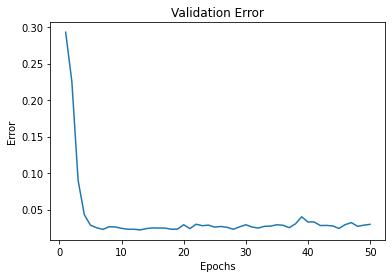

In [97]:
model_path = pathlib.Path(f"./models/autoencoder_bs{batch_size}_lr{learning_rate}")
model_path.mkdir(parents=True, exist_ok=True)

num_epochs = 50 

train_loss = np.zeros(num_epochs)
val_error = np.zeros(num_epochs)

for epoch in range(num_epochs):
    running_loss = 0 
    for images, labels in train_loader: 
        # ensure labels are same size and type
        labels = labels.unsqueeze(1).float()
        # forward pass
        outputs = encoder(images)
        loss_value = loss(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        # for statistics
        running_loss += loss_value.item()
    # compute average loss 
    train_loss[epoch] = running_loss / num_steps
    # evaluate on validation set
    val_error[epoch] = evaluate(encoder, val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_value.item():.6f}, Validation Error: {val_error[epoch]:.6f}")
    # save model after each epoch
    torch.save(encoder.state_dict(), model_path / f"epoch_{epoch+1}")

# show total loss
plt.title("Total Loss")
plt.plot(range(1, len(train_loss) + 1), train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.title("Validation Error")
plt.plot(range(1, len(val_error) + 1), val_error)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()